In [1]:
import os
os.environ["WEBBPSF_PATH"] = 'webbpsf-data'
os.environ["WEBBPSF_EXT_PATH"] = 'webbpsf-data'
os.environ["PYSYN_CDBS"] = "cdbs"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]='False'
import sys
sys.path.append('/home/blewis/GRaTeR-JAX')

from utils.objective_functions import jax_model, objective_model, objective_fit, log_likelihood, Parameter_Index,residuals
from utils.new_SLD_utils import DoubleHenyeyGreenstein_SPF, InterpolatedUnivariateSpline_SPF, EMP_PSF, DustEllipticalDistribution2PowerLaws, Winnie_PSF
from utils.SLD_ojax import ScatteredLightDisk
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
jax.config.update("jax_enable_x64", True)
from astropy.io import fits
import pandas as pd
from statistical_analysis.optimize_framework import OptimizeUtils


/home/blewis/anaconda3/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


webbpsf_ext log messages of level WARN and above will be shown.
webbpsf_ext log outputs will be directed to the screen.
CuPy succesfully imported. Using GPU where applicable. Set use_gpu=False to override this functionality.


Step 1: Import a GPI image as your target disk.

In [2]:
image_data = pd.read_csv('../GPI_data/image_info_filt.csv')
image_data.set_index("Name", inplace=True)
image_data.columns = ["Radius", "Inclination", "Position Angle", "Distance", "Knots"]
print(image_data)

                Radius  Inclination  Position Angle  Distance  Knots
Name                                                                
hd145560_H_pol    85.3         43.9           221.5    120.44    7.0
hd146897_H_pol    85.0         84.0           293.9    131.50    9.0
ceant_H_pol       29.8         13.1           271.0     34.03    7.0
hd111520_H_pol    81.0         88.0           165.0    108.94    7.0
hd115600_H_pol    46.0         80.0            27.5    109.62    7.0
hd129590_H_pol    66.9         75.7           121.7    136.04    9.0
hd117214_H_pol    60.2         71.0           359.8    107.61   11.0
hd35841_H_pol     60.3         84.9           345.8    103.68    7.0
hd30447_H_pol     83.0         83.0            32.3     80.54    7.0
hd32297_H_pol     98.4         88.4            47.9    132.79   13.0
hd110058_H_pol    39.0         84.0           335.0    129.98    5.0
hd111161_H_pol    72.4         62.1           263.2    109.43    7.0
hd157587_H_pol    79.0         70.

Filename: ../GPI_data/hd117214_H_pol.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     496   ()      
  1  SCI           1 ImageHDU       138   (281, 281, 4)   float32   
  2  DQ            3 ImageHDU        64   (281, 281, 2)   uint8   


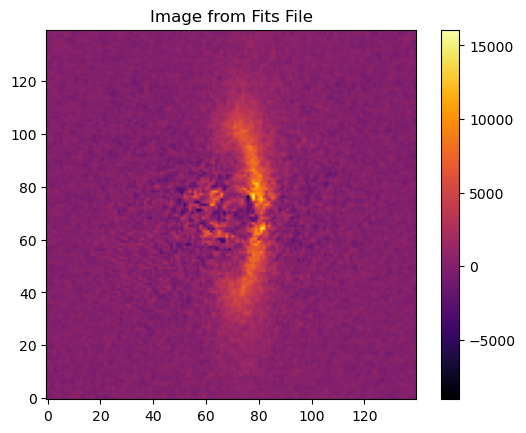

In [19]:
name = "hd117214_H_pol"
fits_image_filepath = "../GPI_data/" + str(name) + ".fits"
hdul = fits.open(fits_image_filepath)
row = image_data.loc[name]

#Displays File Info
hdul.info()

# Gets Image
target_image = OptimizeUtils.process_image(hdul['SCI'].data[1,:,:])*100

# Displays Image
plt.imshow(target_image, origin='lower', cmap='inferno')
plt.title("Image from Fits File")
plt.colorbar()

Now to try the optimization!

In [20]:
spf_params = InterpolatedUnivariateSpline_SPF.params
psf_params = EMP_PSF.params
spf_params['knot_values'] = [1,1,.8,.6,.2,.1]
spf_params['num_knots'] = 6

disk_params = Parameter_Index.disk_params
disk_params['sma'] = row["Radius"]
disk_params['inclination'] = row["Inclination"]
disk_params['position_angle'] = row["Position Angle"]

misc_params = Parameter_Index.misc_params
misc_params['distance'] = row["Distance"]

img = objective_model(disk_params, spf_params, psf_params, misc_params,
                        ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF)

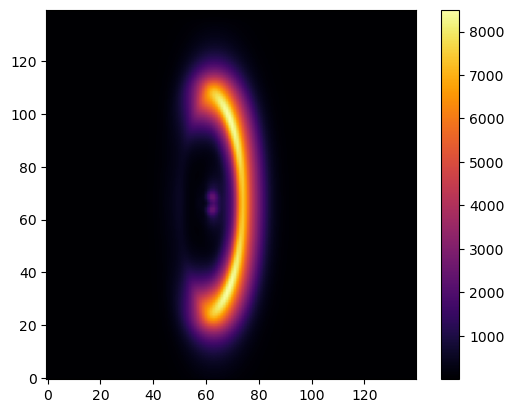

In [21]:
plt.imshow(img, origin='lower', cmap='inferno')
plt.colorbar()
plt.show()

Log-Likelihood: -334764214.0260587
10000000000.0


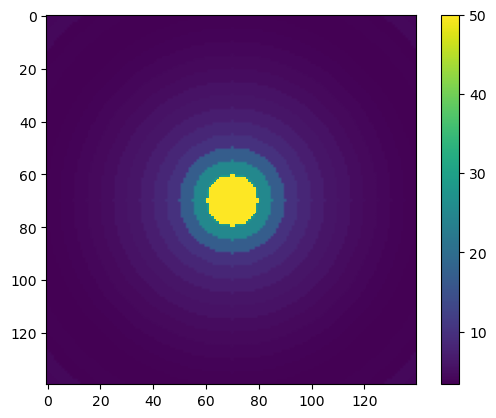

In [22]:
err_map = OptimizeUtils.process_image(OptimizeUtils.create_empirical_err_map(hdul['SCI'].data[2,:,:])) #, outlier_pixels=[(57, 68)]))
plt.imshow(err_map,vmax=50)
plt.colorbar()
print(f'Log-Likelihood: {log_likelihood(img, target_image, err_map)}')
print(np.max(err_map))

In [23]:
from scipy.optimize import minimize
jax.config.update("jax_debug_nans", True)

In [24]:
fit_keys = ['sma', 'inclination', 'position_angle','knot_values']

llp = lambda x: -objective_fit([x[0], x[1], x[2], x[3:]], fit_keys, disk_params, spf_params, psf_params, misc_params,
                              ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF, target_image,
                              err_map)

start_disk_params = disk_params
start_disk_params['sma'] = disk_params['sma']
start_disk_params['inclination'] = disk_params['inclination']
start_disk_params['position_angle'] = disk_params['position_angle']

init_x = jnp.concatenate([jnp.array([start_disk_params['sma'], start_disk_params['inclination'], start_disk_params['position_angle']]), np.asarray([1,1,.8,.6,.2,.1])])
print(init_x)

[6.020e+01 7.100e+01 3.598e+02 1.000e+00 1.000e+00 8.000e-01 6.000e-01
 2.000e-01 1.000e-01]


In [25]:
sigma2 = jnp.power(err_map, 2)
print(np.min(jnp.log(err_map)))

1.2056471


In [26]:
from scipy.optimize import minimize
jax.config.update("jax_debug_nans", True)

soln = minimize(llp, init_x, options={'disp': True, 'max_itr': 500})

         Current function value: 115324561.281906
         Iterations: 20
         Function evaluations: 681
         Gradient evaluations: 67


In [27]:
print(soln.x)

[ 6.64845058e+01  6.66582740e+01  3.58520377e+02  1.32479095e+00
  8.28059141e-01  1.88456528e-01  4.86525577e-02 -9.40293838e-03
  9.21494098e-02]


Log-Likelihood: -115392211.29578151


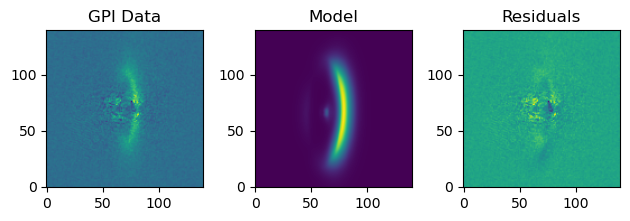

In [28]:
for k in range(len(fit_keys)):
    if k==len(fit_keys)-1:
        spf_params[fit_keys[k]] = np.abs(soln.x[k:])
    else:
        disk_params[fit_keys[k]] = soln.x[k]

best_fit_disk = objective_model(disk_params, spf_params, psf_params, misc_params,
                        ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF)

fig, ax = plt.subplots(1,3)
ax[0].imshow(target_image,origin='lower')
ax[1].imshow(best_fit_disk,origin='lower')
ax[2].imshow(target_image-best_fit_disk,origin='lower')
ax[0].set_title('GPI Data')
ax[1].set_title('Model')
ax[2].set_title('Residuals')
plt.tight_layout()

print(f'Log-Likelihood: {log_likelihood(best_fit_disk, target_image, err_map)}')

In [29]:
from utils.objective_functions import plot_fit_output

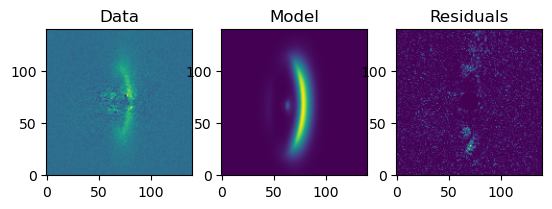

In [32]:
plot_fit_output(target_image,err_map,best_fit_disk,save=True,target_name=name)

In [31]:
fit_keys = ['sma', 'inclination', 'position_angle', 'alpha_in','alpha_out','ksi0','gamma','beta','x_center','y_center','knot_values']

llp = lambda x: -objective_fit([x[0], x[1], x[2], x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10:]], fit_keys, disk_params, spf_params, psf_params, misc_params,
                              ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF, target_image,
                              err_map)

start_disk_params = disk_params
start_disk_params['sma'] = disk_params['sma']
start_disk_params['inclination'] = disk_params['inclination']
start_disk_params['position_angle'] = disk_params['position_angle']

init_x = jnp.concatenate([jnp.array([start_disk_params['sma'], start_disk_params['inclination'], start_disk_params['position_angle'],5,-5,3,2,1,70,70]), jnp.ones(6)])
print(init_x)

[ 66.4845058   66.65827396 358.52037667   5.          -5.
   3.           2.           1.          70.          70.
   1.           1.           1.           1.           1.
   1.        ]


In [16]:
soln = minimize(llp, init_x, options={'disp': True, 'max_itr': 500})

         Current function value: 5979510.264742
         Iterations: 14
         Function evaluations: 793
         Gradient evaluations: 46


In [17]:
print(soln.x)
print(-soln.fun)

[ 6.49942133e+01  7.24336078e+01  3.60242496e+02 -3.78738415e+00
 -7.34091339e+00  2.94085497e+00  5.11254846e+00  7.40407742e+00
  6.38076924e+01  6.80114481e+01  8.42815706e-01 -1.96798341e-01
  5.20357784e-02 -5.91218496e-03 -2.42801949e-02  2.44949841e-01]
-5979510.264741781


In [ ]:
import pickle

with open(name+'_init.pickle', 'wb') as file:
    pickle.dump(soln.x, file)

In [ ]:
with open(name+'_init.pickle', 'rb') as file:
    loaded_data = pickle.load(file)

In [ ]:
print(loaded_data)

In [ ]:
for k in range(len(fit_keys)):
    if k==len(fit_keys)-1:
        spf_params[fit_keys[k]] = soln.x[k:]
    else:
        disk_params[fit_keys[k]] = soln.x[k]
print(disk_params)
best_fit_disk = objective_model(disk_params, spf_params, psf_params, misc_params,
                        ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF)

fig, ax = plt.subplots(1,3)
ax[0].imshow(target_image,origin='lower')
ax[1].imshow(best_fit_disk,origin='lower')
ax[2].imshow(target_image-best_fit_disk,origin='lower')
ax[0].set_title('GPI Data')
ax[1].set_title('Model')
ax[2].set_title('Residuals')
print(f'Log-Likelihood: {log_likelihood(best_fit_disk, target_image, err_map)}')

In [ ]:
import GPI_code.GPI_init_fits

In [ ]:
name = "hd117214_H_pol"
GPI_code.GPI_init_fits.fit_disk(name)